In [1]:
import re
import difflib
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
csv_file_path = '/home/nogaschw/Codeworkout/cleaned_code.csv'
df1 = pd.read_csv(csv_file_path, sep=',')

In [3]:
def arrange_data(df):
    df = df.sort_values('timestamp', ascending=True)
    df = df.groupby(['student_id', 'problem_id', 'course_id']).apply(lambda x: pd.Series({
        'ServerTimestamp': x['timestamp'].tolist(),
        'score': x['score'].tolist(),
        'source_code': x['clean_code'].tolist()
    })).reset_index()
    df['num_snapshots'] = df['source_code'].apply(lambda x: len(x))
    df['time_to_solve'] = df['ServerTimestamp'].apply(lambda x: (pd.to_datetime(x[-1]) - pd.to_datetime(x[0])).seconds)
    df['time_between_snapshots'] = df['ServerTimestamp'].apply(lambda x: [(pd.to_datetime(x[i]) - pd.to_datetime(x[i-1])).seconds for i in range(1, len(x))])
    df['success'] = df['score'].apply(lambda x: 1 if x.__contains__(100) else 0) 
    return df

In [4]:
df = arrange_data(df1)

/tmp/ipykernel_938634/1865723633.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['student_id', 'problem_id', 'course_id']).apply(lambda x: pd.Series({


#### Quetion per Student

(array([ 16.,  16.,  33., 141., 448., 641., 214.,  46.,   3.,   1.]),
 array([  1. ,  20.4,  39.8,  59.2,  78.6,  98. , 117.4, 136.8, 156.2,
        175.6, 195. ]),
 <BarContainer object of 10 artists>)

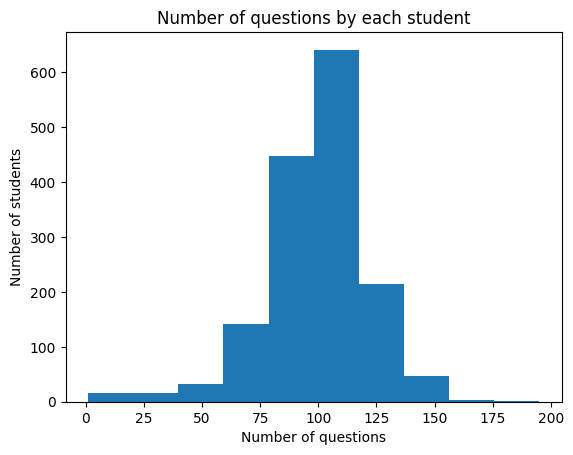

In [5]:
x = sorted(df.groupby('student_id')['problem_id'].nunique())
plt.title('Number of questions by each student')
plt.xlabel('Number of questions')
plt.ylabel('Number of students')
plt.hist(x)

#### Successful

In [6]:
df['Max.Score'] = df['score'].apply(lambda x: max(x))
successfull = df[df['Max.Score'] == 100]
not_successfull = df[df['Max.Score'] < 100]
all = len(successfull) + len(not_successfull)
len(successfull), len(not_successfull), all, (len(not_successfull)/ all) * 100

(115052, 40017, 155069, 25.805931553050577)

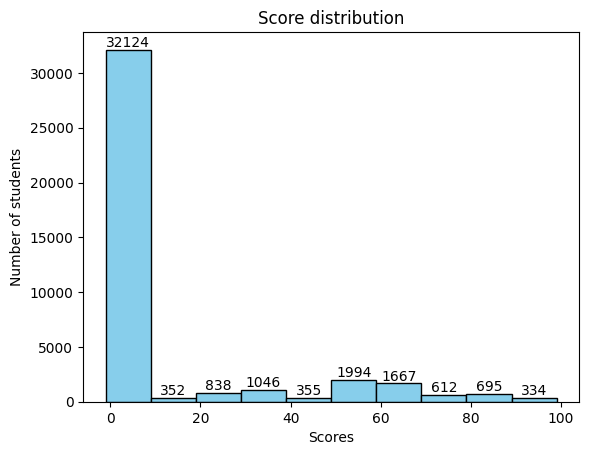

In [7]:
x = not_successfull['Max.Score']
plt.title('Score distribution')
plt.xlabel('Scores')
plt.ylabel('Number of students')
n, bins, patches = plt.hist(x, color='skyblue', edgecolor='black')
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height(), int(patches[i].get_height()), ha='center', va='bottom')

plt.show()

#### Snapshots per Student

In [8]:
snapshot_stat = df.groupby(['problem_id']).apply(lambda x: pd.Series({
    'number_of_students': x['student_id'].nunique(), 
    'min_snapshots': x['num_snapshots'].min(),
    'max_snapshots': x['num_snapshots'].max(),
    'mean_snapshots': x['num_snapshots'].mean(),
    'median_snapshots': x['num_snapshots'].median(),
})).reset_index()

snapshot_stat

/tmp/ipykernel_938634/1422259441.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  snapshot_stat = df.groupby(['problem_id']).apply(lambda x: pd.Series({


,problem_id,number_of_students,min_snapshots,max_snapshots,mean_snapshots,median_snapshots
0,AirStrike,1.0,1.0,1.0,1.000000,1.0
1,Airstrike,558.0,1.0,566.0,105.874552,88.0
2,CAESAR,1.0,1.0,1.0,1.000000,1.0
3,CS110_Ingenuity_Simulator_Spiral_1,417.0,1.0,773.0,123.829736,106.0
4,CS110_Ingenuity_Simulator_Spiral_2,286.0,1.0,306.0,45.216783,36.0
...,...,...,...,...,...,...
461,pex2,17.0,1.0,10.0,1.941176,1.0
462,pex2_gc,36.0,1.0,8.0,2.472222,2.0
463,pex3,484.0,1.0,503.0,101.917355,82.0
464,recon,1.0,1.0,1.0,1.000000,1.0


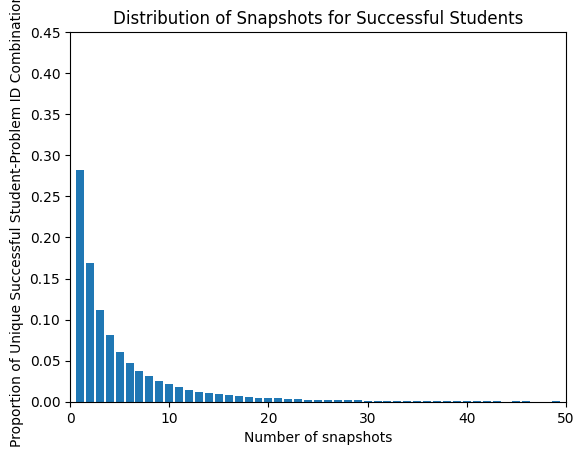

In [9]:
plt.title('Distribution of Snapshots for Successful Students')
plt.xlabel('Number of snapshots')
plt.ylabel('Proportion of Unique Successful Student-Problem ID Combinations')
plt.xlim(0, 50)
plt.ylim(0, 0.45)

success = df[df['success'] == 1]['num_snapshots']
success = success.value_counts(normalize=True).sort_index()
plt.bar(success.index, success.values)
plt.show()

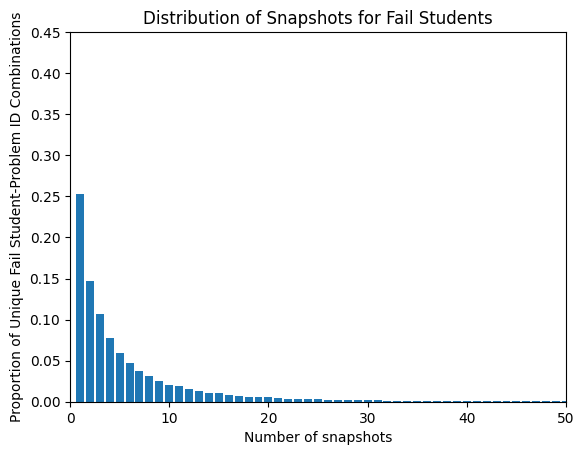

In [10]:
plt.title('Distribution of Snapshots for Fail Students')
plt.xlabel('Number of snapshots')
plt.ylabel('Proportion of Unique Fail Student-Problem ID Combinations')
plt.xlim(0, 50)
plt.ylim(0, 0.45)

fail = df[df['success'] == 0]['num_snapshots']
fail = fail.value_counts(normalize=True).sort_index()
plt.bar(fail.index, fail.values)
plt.show()

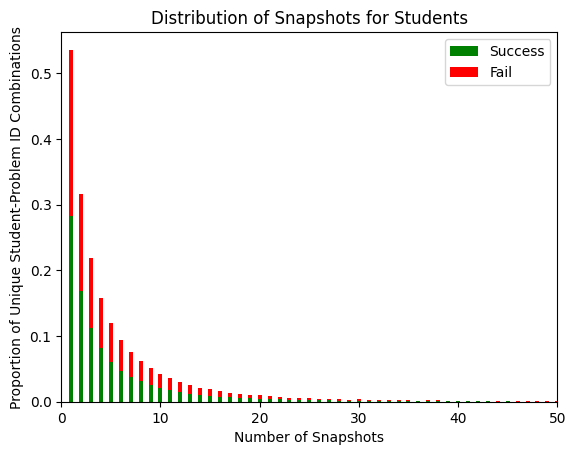

In [11]:
combined_index = success.index.union(fail.index)
success = success.reindex(combined_index, fill_value=0)
fail = fail.reindex(combined_index, fill_value=0)

plt.xlim(0, 50)

bar_width = 0.4
plt.bar(combined_index, success.values, width=bar_width, color='g', label='Success')
plt.bar(combined_index, fail.values, bottom=success.values, width=bar_width, color='r', label='Fail')

plt.title('Distribution of Snapshots for Students')
plt.xlabel('Number of Snapshots')
plt.ylabel('Proportion of Unique Student-Problem ID Combinations')
plt.legend()
plt.show()

#### Time

In [12]:
df_without_one_snapshot = df[df['num_snapshots'] > 1]
time_stat = df_without_one_snapshot.groupby(['problem_id']).apply(lambda x: pd.Series({
    'number_of_students': x['student_id'].nunique(), 
    'min_time_to_solve': x['time_to_solve'].min()/60,
    'max_time_to_solve': x['time_to_solve'].max()/60,
    'mean_time_to_solve': x['time_to_solve'].mean()/60,
    'median_time_to_solve': x['time_to_solve'].median()/60,
    'mean_time_between_snapshots': x['time_between_snapshots'].apply(lambda y: sum(y) / len(y)).mean()/60,
    'median_time_between_snapshots': x['time_between_snapshots'].apply(lambda y: sum(y) / len(y)).median()/60,
})).reset_index()

time_stat # in minutes

/tmp/ipykernel_938634/908152318.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_stat = df_without_one_snapshot.groupby(['problem_id']).apply(lambda x: pd.Series({


,problem_id,number_of_students,min_time_to_solve,max_time_to_solve,mean_time_to_solve,median_time_to_solve,mean_time_between_snapshots,median_time_between_snapshots
0,Airstrike,548.0,0.183333,1439.466667,575.233790,489.183333,53.553619,42.540653
1,CS110_Ingenuity_Simulator_Spiral_1,413.0,0.383333,1436.150000,642.030105,537.533333,41.018773,32.382784
2,CS110_Ingenuity_Simulator_Spiral_2,277.0,0.066667,1438.633333,532.705836,441.233333,68.497304,48.447759
3,CS110_Ingenuity_Simulator_Spiral_3,184.0,0.200000,1429.583333,445.622645,299.725000,57.379048,26.502397
4,CS110_Ingenuity_Simulator_spiral_2,1.0,1367.100000,1367.100000,1367.100000,1367.100000,62.380000,62.380000
...,...,...,...,...,...,...,...,...
453,lsn9_triangle,170.0,0.116667,1395.383333,180.597647,3.691667,60.155991,0.975000
454,pex1,468.0,2.216667,1438.733333,534.747756,348.450000,56.974786,36.585321
455,pex2,5.0,0.550000,998.966667,391.156667,9.600000,194.886667,3.958333
456,pex2_gc,20.0,1.183333,1363.933333,303.635000,67.450000,209.238782,31.295238


In [13]:
df_at_least_10 = df_without_one_snapshot[df_without_one_snapshot['num_snapshots'] >= 10]

time_vs_snapshots = {}
for index, row in df_at_least_10.iterrows():
    if row['problem_id'] not in time_vs_snapshots:
        time_vs_snapshots[row['problem_id']] = {}
    for i in range (1, row['num_snapshots']):
        if i not in time_vs_snapshots[row['problem_id']]:
            time_vs_snapshots[row['problem_id']][i] = []
        time_vs_snapshots[row['problem_id']][i].append(row['time_between_snapshots'][i - 1])

time_vs_snapshots
avg_snapshots_vs_time = {}
len_snapshots_vs_time = {}
for key, value in time_vs_snapshots.items():
    avg_snapshots_vs_time[key] = {}
    len_snapshots_vs_time[key] = {}
    for k, v in value.items():
        avg_snapshots_vs_time[key][k] = sum(v) / len(v)
        len_snapshots_vs_time[key][k] = len(v)

data = []

# Iterate over items in avg_snapshots_vs_score
for key, value in avg_snapshots_vs_time.items():
    for k, v in value.items():
        # Append a dictionary to the list
        data.append({'problem_id': key, 'Snapshot': k, 'Time between Snapshots': v, 'Number of Students': len_snapshots_vs_time[key][k]})

len_snapshots_vs_time = pd.DataFrame(data)


In [14]:
len_snapshots_vs_time = len_snapshots_vs_time[len_snapshots_vs_time['Number of Students'] > 10]
len_snapshots_vs_time['Time between Snapshots'] = len_snapshots_vs_time['Time between Snapshots'].apply(lambda x: x / 60)

Text(0.5, 1.0, 'Time between Snapshots vs Snapshots')

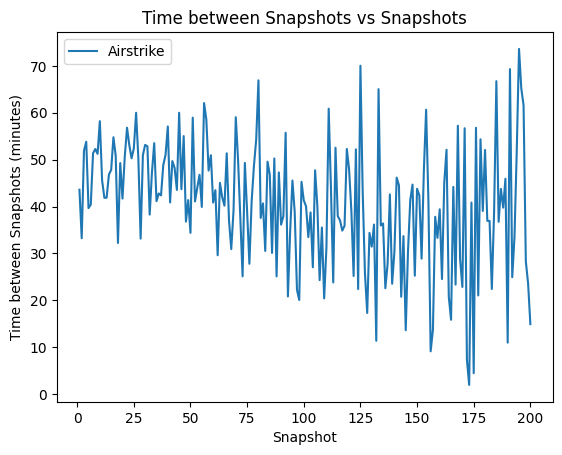

In [15]:
save_data = {}
fig, ax = plt.subplots()
for key, grp in len_snapshots_vs_time.head(200).groupby('problem_id'):
    save_data[key] = grp
    ax.plot(grp['Snapshot'], grp['Time between Snapshots'], label=key)
ax.legend()
plt.xlabel('Snapshot')
plt.ylabel('Time between Snapshots (minutes)')
plt.title('Time between Snapshots vs Snapshots')

Checking why consecutive snapshots are done with almost zero delay between them

In [16]:
for key, value in save_data.items():
    print(f"Minimum time to solve {key} is {value['Time between Snapshots'].min().round(2)}")

Minimum time to solve Airstrike is 1.98


Time between snapshots for e3bdbc32-4ce3-4e28-b3f9-1f0bb645b1ec is [18, 160, 610, 561, 82, 44, 108, 83880, 1361] (seconds)
Time between snapshots for 94d651ac-985a-4ce2-8c37-baa61b721155 is [103, 26, 61, 10, 28, 186, 35, 14, 28812] (seconds)
Time between snapshots for e882d7d4-6281-40dd-b04d-03eef51ede87 is [33, 170, 45, 140, 72, 249, 6655, 23, 33] (seconds)
Time between snapshots for 380117b1-2145-4f11-b6d8-eef5b15c1986 is [66, 43194, 32, 225, 37, 29, 379, 401, 41821] (seconds)
Time between snapshots for b60892cd-95ea-4cd3-a703-9b55fe987818 is [414, 322, 8395, 9237, 278, 11, 206, 261, 77985] (seconds)


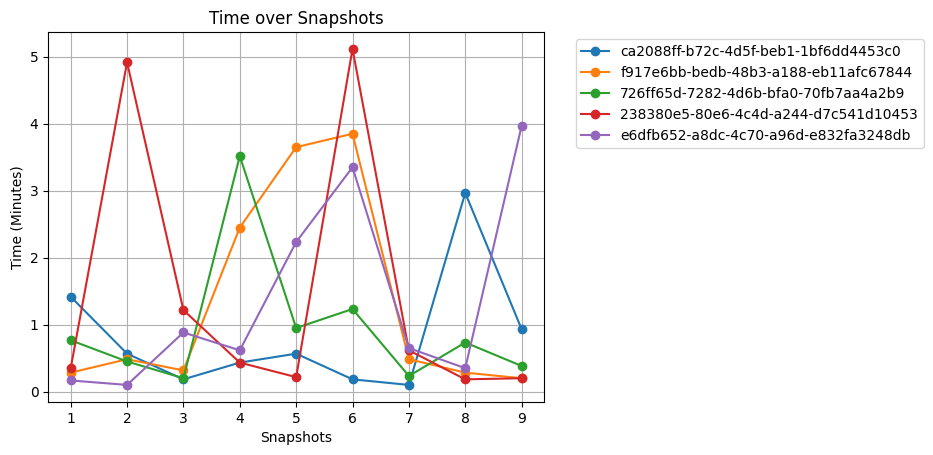

In [17]:
save_data = {}
random_10_fail = not_successfull[not_successfull["num_snapshots"] == 10].sample(10)
for index, row in random_10_fail.iterrows():
    if max(row['time_between_snapshots']) / 60 > 10:
        print(f"Time between snapshots for {row['student_id']} is {row['time_between_snapshots']} (seconds)")
        continue
    save_data[index] = row
    snapshots = list(range(1, row['num_snapshots']))
    t = [x/60 for x in row['time_between_snapshots']]
    plt.plot(snapshots, t, marker='o', label=row['student_id'])

plt.xlabel('Snapshots')
plt.ylabel('Time (Minutes)')
plt.title('Time over Snapshots')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

#### Changes in Lines between Snapshots

In [18]:
def get_diffs(snapshots):
    diffs = []
    for i in range(1, len(snapshots)):
        diff = difflib.unified_diff(snapshots[i-1].splitlines(), snapshots[i].splitlines())
        diffs.append(list(diff))
    return diffs

df['diffs'] = df['source_code'].apply(lambda x: get_diffs(x))
df_lines = df[df['source_code'].apply(lambda x: len(x) > 1) & df['diffs'].apply(lambda x: len(x) > 0 and len(x[0]) > 0)]

In [19]:
def get_deleted_inserted_lines(diffs):
    deleted = []
    inserted = []
    for diff in diffs:
        del_lines = 0
        ins_lines = 0
        for line in diff:
            if line.startswith('-'):
                del_lines += 1
            elif line.startswith('+'):
                ins_lines += 1
        deleted.append(del_lines)
        inserted.append(ins_lines)
    return deleted, inserted

df_lines['deleted'], df_lines['inserted'] = zip(*df_lines['diffs'].apply(lambda x: get_deleted_inserted_lines(x)))

/tmp/ipykernel_938634/97789572.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lines['deleted'], df_lines['inserted'] = zip(*df_lines['diffs'].apply(lambda x: get_deleted_inserted_lines(x)))
/tmp/ipykernel_938634/97789572.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lines['deleted'], df_lines['inserted'] = zip(*df_lines['diffs'].apply(lambda x: get_deleted_inserted_lines(x)))


In [20]:
success_with_snapshots = df_lines[df_lines['success'] == 1]
number_of_snapshots_success = success_with_snapshots['num_snapshots'].sum()

fail_with_snapshots = df_lines[df_lines['success'] == 0]
number_of_snapshots_fail = fail_with_snapshots['num_snapshots'].sum()
print(f"Number of snapshots for successful students: {number_of_snapshots_success}")
print(f"Number of snapshots for fail students: {number_of_snapshots_fail}")

Number of snapshots for successful students: 584178
Number of snapshots for fail students: 414816


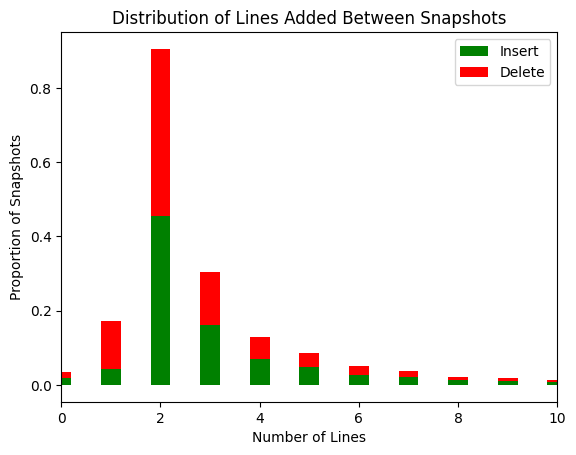

In [21]:
inserted = fail_with_snapshots['inserted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots_fail
deleted = fail_with_snapshots['deleted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots_fail

combined_index = inserted.index.union(deleted.index)
inserted = inserted.reindex(combined_index, fill_value=0)
deleted = deleted.reindex(combined_index, fill_value=0)

bar_width = 0.4

plt.bar(combined_index, inserted.values, width=bar_width, color='g', label='Insert')
plt.bar(combined_index, deleted.values, bottom=inserted.values, width=bar_width, color='r', label='Delete')

plt.xlim(0, 10)
plt.title('Distribution of Lines Added Between Snapshots')
plt.xlabel('Number of Lines')
plt.ylabel('Proportion of Snapshots')
plt.legend()
plt.show()

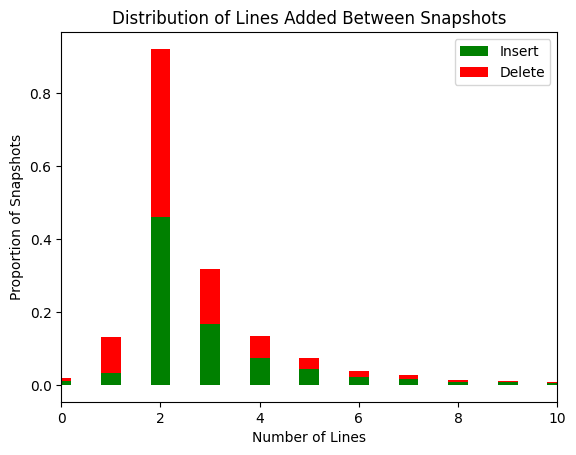

In [22]:
inserted = success_with_snapshots['inserted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots_success
deleted = success_with_snapshots['deleted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots_success

combined_index = inserted.index.union(deleted.index)
inserted = inserted.reindex(combined_index, fill_value=0)
deleted = deleted.reindex(combined_index, fill_value=0)


plt.bar(combined_index, inserted.values, width=bar_width, color='g', label='Insert')
plt.bar(combined_index, deleted.values, bottom=inserted.values, width=bar_width, color='r', label='Delete')

plt.xlim(0, 10)
plt.title('Distribution of Lines Added Between Snapshots')
plt.xlabel('Number of Lines')
plt.ylabel('Proportion of Snapshots')
plt.legend()
plt.show()

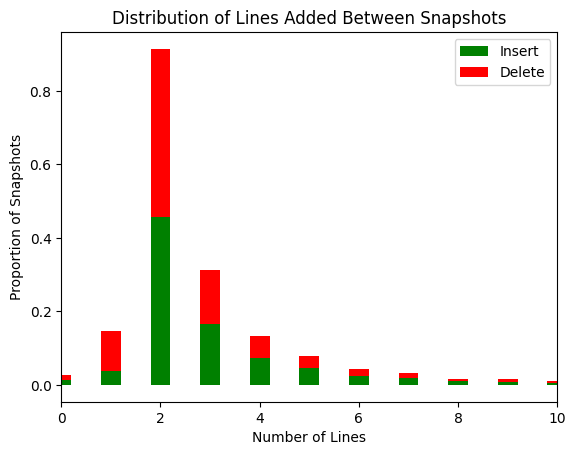

In [23]:
inserted = df_lines['inserted'].apply(pd.Series).stack().value_counts().sort_index() / (number_of_snapshots_success + number_of_snapshots_fail)
deleted = df_lines['deleted'].apply(pd.Series).stack().value_counts().sort_index() / (number_of_snapshots_success + number_of_snapshots_fail)

combined_index = inserted.index.union(deleted.index)
inserted = inserted.reindex(combined_index, fill_value=0)
deleted = deleted.reindex(combined_index, fill_value=0)

bar_width = 0.4

plt.bar(combined_index, inserted.values, width=bar_width, color='g', label='Insert')
plt.bar(combined_index, deleted.values, bottom=inserted.values, width=bar_width, color='r', label='Delete')

plt.xlim(0, 10)
plt.title('Distribution of Lines Added Between Snapshots')
plt.xlabel('Number of Lines')
plt.ylabel('Proportion of Snapshots')
plt.legend()
plt.show()

I decided to define the number of changed lines as the maximum between the inserted lines and the deleted lines.

In [24]:
# Look on specific quetions
question = 'a1_1_dorms'
specific_quetion_success = df_lines[(df_lines['problem_id'] == question) & (df_lines['num_snapshots'] >= 8) & (df_lines['num_snapshots'] <= 10) & (df_lines['success'] == 1)]
specific_quetion_success = specific_quetion_success.head(8)

specific_quetion_fail = df_lines[(df_lines['problem_id'] == question) & (df_lines['num_snapshots'] >= 8) & (df_lines['num_snapshots'] <= 10) & (df_lines['success'] == 0)]
specific_quetion_fail = specific_quetion_fail.head(8)

In [25]:
def plot_snapshot(specific_quetion):
    for index, row in specific_quetion.iterrows():
        snapshots = list(range(1, row['num_snapshots']))
        plt.plot(snapshots, max(row['deleted'], row['inserted']), marker='o', label=row['student_id'])

    plt.xlabel('Snapshots')
    plt.ylabel('Changed Lines')
    plt.title('Changed Lines over Snapshots')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()


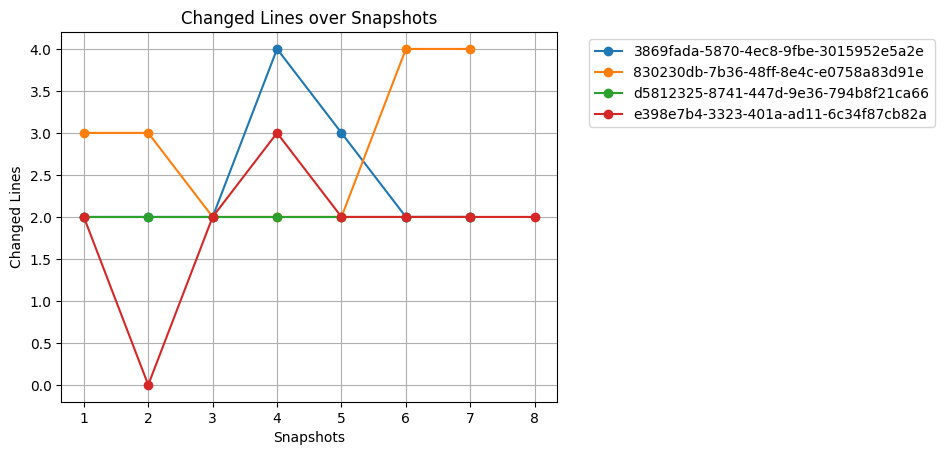

In [26]:
plot_snapshot(specific_quetion_success)

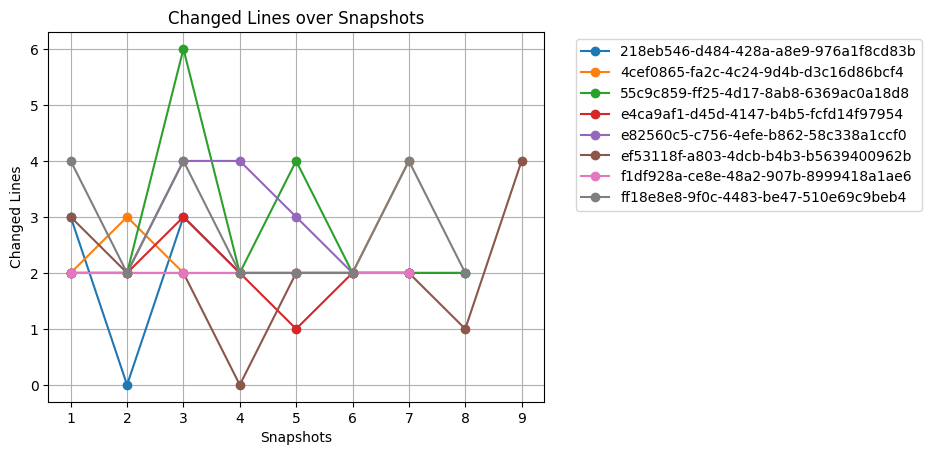

In [27]:
plot_snapshot(specific_quetion_fail)

#### Explore Students Who not Finish The Question

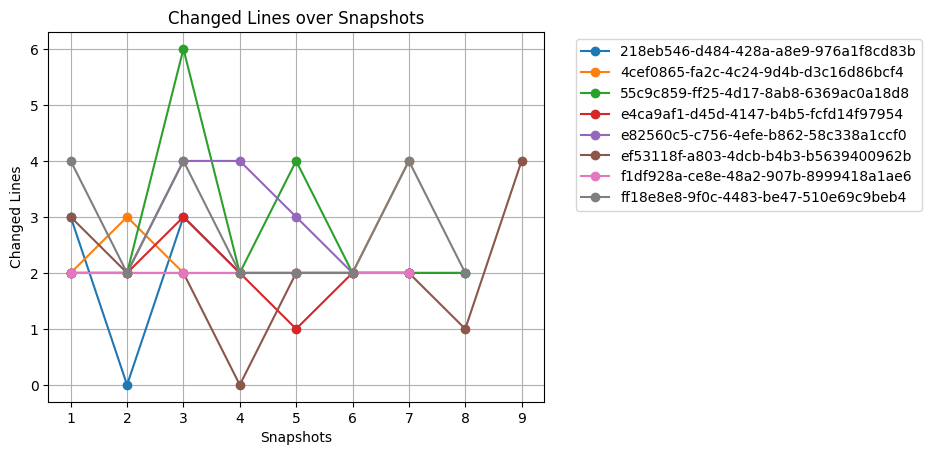

In [28]:
plot_snapshot(specific_quetion_fail)

In [29]:
df_fail = df[df['success'] == 0]

snapshots_vs_score = {}
for index, row in df_fail.iterrows():
    if row['problem_id'] not in snapshots_vs_score:
        snapshots_vs_score[row['problem_id']] = {}
    for i in range (1, row['num_snapshots'] + 1):
        if i not in snapshots_vs_score[row['problem_id']]:
            snapshots_vs_score[row['problem_id']][i] = []
        snapshots_vs_score[row['problem_id']][i].append(row['score'][i - 1])

avg_snapshots_vs_score = {}
len_snapshots_vs_score = {}
for key, value in snapshots_vs_score.items():
    avg_snapshots_vs_score[key] = {}
    len_snapshots_vs_score[key] = {}
    for k, v in value.items():
        avg_snapshots_vs_score[key][k] = sum(v) / len(v)
        len_snapshots_vs_score[key][k] = len(v)

data = []

# Iterate over items in avg_snapshots_vs_score
for key, value in avg_snapshots_vs_score.items():
    for k, v in value.items():
        # Append a dictionary to the list
        data.append({'problem_id': key, 'Snapshot': k, 'Average Score': v, 'Number of Students': len_snapshots_vs_score[key][k]})

df_snapshots_vs_score = pd.DataFrame(data)
df_snapshots_vs_score

,problem_id,Snapshot,Average Score,Number of Students
0,Airstrike,1,-0.978495,558
1,Airstrike,2,-0.972628,548
2,Airstrike,3,-0.977901,543
3,Airstrike,4,-0.987085,542
4,Airstrike,5,-0.992523,535
...,...,...,...,...
15185,CS110_Ingenuity_Simulator_spiral_2,42,-1.000000,1
15186,CS110_Ingenuity_Simulator_spiral_2,43,-1.000000,1
15187,CS110_Ingenuity_Simulator_spiral_2,44,-1.000000,1
15188,CS110_Ingenuity_Simulator_spiral_2,45,-1.000000,1


In [30]:
# arrange by limit to 10 snapshots and at least 5 students
df_snapshots_vs_score_10 = df_snapshots_vs_score[(df_snapshots_vs_score['Snapshot'] <= 10) & (df_snapshots_vs_score['Number of Students'] >= 5)]

In [31]:
df_all = df_snapshots_vs_score.groupby('Snapshot').apply(lambda x: pd.Series({
    'mean_score': x['Average Score'].mean(),
    'number_of_students': x['Number of Students'].sum(),
})).reset_index()

/tmp/ipykernel_938634/2873527491.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all = df_snapshots_vs_score.groupby('Snapshot').apply(lambda x: pd.Series({


The mean score is problemtic (The number of student is decrease)

<Axes: title={'center': 'Score of Student not Finish the Question by Snapshots'}, xlabel='Snapshots', ylabel='Mean Score'>

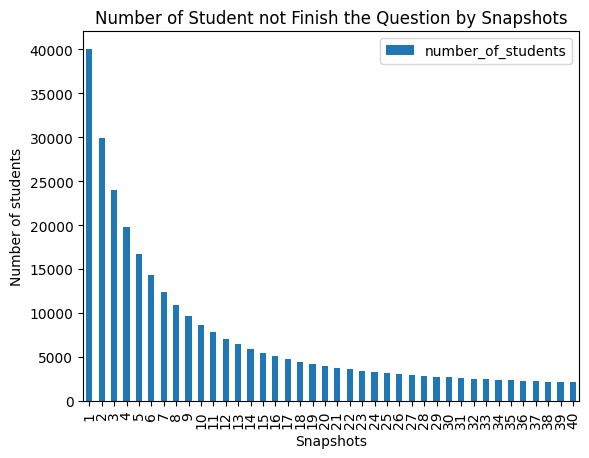

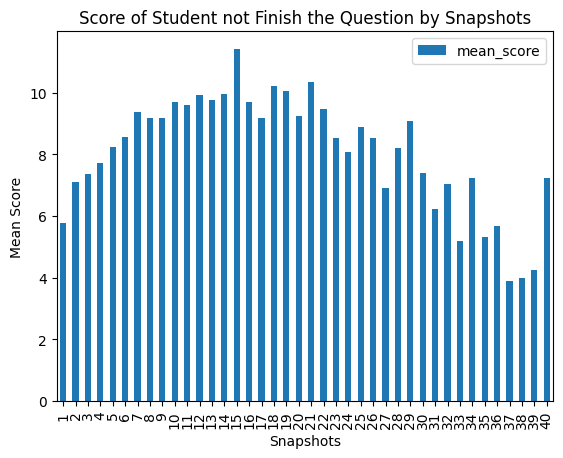

In [32]:
df_snapshots_vs_score_40 = df_all.head(40)
df_snapshots_vs_score_40.plot(x='Snapshot', y='number_of_students', kind='bar', xlabel='Snapshots', ylabel='Number of students', title='Number of Student not Finish the Question by Snapshots')
df_snapshots_vs_score_40.plot(x='Snapshot', y='mean_score', kind='bar', xlabel='Snapshots', ylabel='Mean Score', title='Score of Student not Finish the Question by Snapshots')


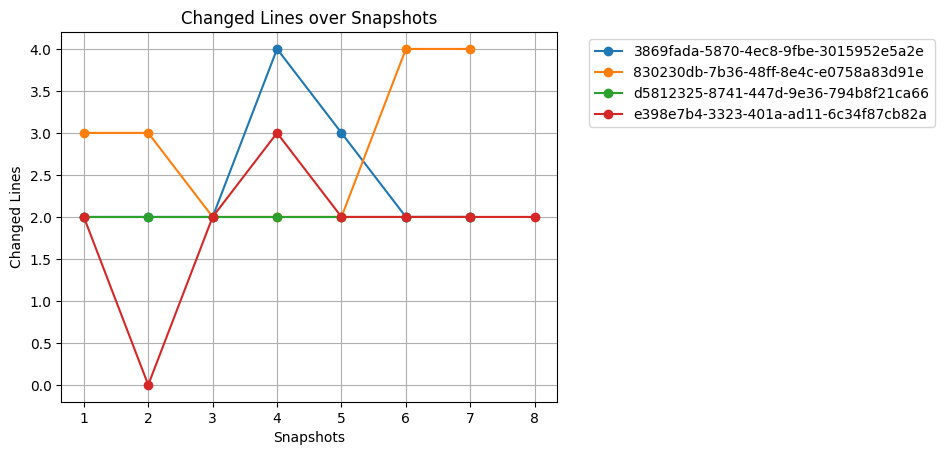

In [33]:
plot_snapshot(specific_quetion_success)

# Define Struggling Student

In [34]:
all_courses_without_one_snapshot = df[df['num_snapshots'] > 1]
df_without_break = all_courses_without_one_snapshot[all_courses_without_one_snapshot['time_between_snapshots'].apply(lambda x: max(x) <= 600)]
df_without_break['Max.Score'] = df_without_break['score'].apply(lambda x: max(x))

df_1_score = df_without_break[df_without_break['success'] == 0]

len_struggling_by_score = len(df_1_score) 
len_data =len(df_without_break)

(len_struggling_by_score / len_data) * 100

/tmp/ipykernel_938634/278698939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_break['Max.Score'] = df_without_break['score'].apply(lambda x: max(x))


25.097998085923674

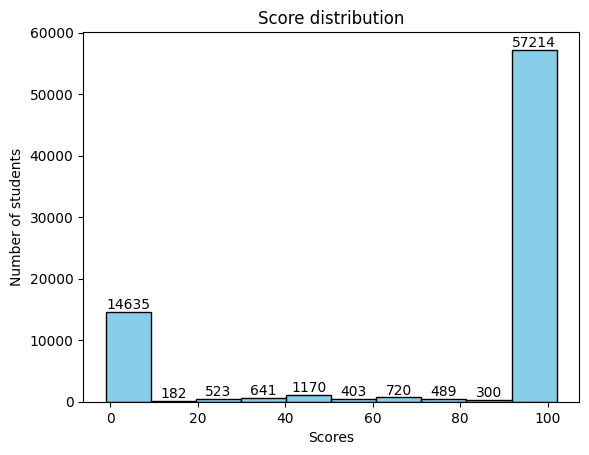

In [35]:
x = df_without_break['Max.Score']
plt.title('Score distribution')
plt.xlabel('Scores')
plt.ylabel('Number of students')
n, bins, patches = plt.hist(x, color='skyblue', edgecolor='black')
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height(), int(patches[i].get_height()), ha='center', va='bottom')

plt.show()

In [36]:
# measure avg without student who take a break (more than 10 minutes between snapshots)
df_without_break_grouped = df_without_break.groupby(['problem_id'])

# Calculate average time to solve for each group
avg_time_to_solve = df_without_break_grouped['time_to_solve'].mean()

# Calculate average attempts for each group
avg_attempts = df_without_break_grouped['num_snapshots'].mean()

variance_time_to_solve = df_without_break_grouped['time_to_solve'].var()

std_dev_time_to_solve = df_without_break_grouped['time_to_solve'].std()

variance_num_snapshots = df_without_break_grouped['num_snapshots'].var()

std_dev_num_snapshots = df_without_break_grouped['num_snapshots'].std()


# Combine the results into a DataFrame
result_df = pd.DataFrame({
    'avg_time_to_solve': avg_time_to_solve,
    'avg_attempts': avg_attempts,
    'variance_time_to_solve': variance_time_to_solve,
    'std_dev_time_to_solve': std_dev_time_to_solve,
    'variance_num_snapshots': variance_num_snapshots,
    'std_dev_num_snapshots': std_dev_num_snapshots
}).reset_index()

result_df


,problem_id,avg_time_to_solve,avg_attempts,variance_time_to_solve,std_dev_time_to_solve,variance_num_snapshots,std_dev_num_snapshots
0,Airstrike,876.062500,7.312500,5.791742e+05,761.034950,34.362500,5.861954
1,CS110_Ingenuity_Simulator_Spiral_1,277.333333,3.000000,3.745387e+04,193.530015,1.200000,1.095445
2,CS110_Ingenuity_Simulator_Spiral_2,858.050000,9.850000,6.009489e+05,775.208934,75.818421,8.707377
3,CS110_Ingenuity_Simulator_Spiral_3,759.566667,9.633333,6.776638e+05,823.203401,116.516092,10.794262
4,FileIO_echo,520.398810,6.285714,2.812940e+05,530.371547,34.337040,5.859782
...,...,...,...,...,...,...,...
449,lsn9_triangle,153.638889,3.740741,4.090236e+04,202.243328,8.904119,2.983977
450,pex1,1794.870968,14.322581,2.116185e+06,1454.711145,108.092473,10.396753
451,pex2,361.333333,5.000000,8.340233e+04,288.794621,19.000000,4.358899
452,pex2_gc,354.250000,4.000000,7.948225e+04,281.925965,8.000000,2.828427


In [37]:
print("avg time to solve: ", result_df['avg_time_to_solve'].mean())
print("std dev time to solve:",result_df['std_dev_time_to_solve'].mean())

avg time to solve:  310.52795584142194
std dev time to solve: 324.0855385467762


In [38]:
columns = ['student_id', 'problem_id', 'num_snapshots', 'time_to_solve', 'time_between_snapshots', 'Max.Score', 'source_code']

data = [['student_id', 'problem_id', 'num_snapshots', 'time_to_solve', 'time_between_snapshots', 'Max.Score', 'source_code']]

for index, row in df_without_break.iterrows():
    problem = row['problem_id']
    avg = result_df[result_df['problem_id'] == problem]['avg_time_to_solve'].values[0]
    std = result_df[result_df['problem_id'] == problem]['std_dev_time_to_solve'].values[0]
    if row['time_to_solve'] > avg + 1 * std:
        data.append([row['student_id'], row['problem_id'], row['num_snapshots'], row['time_to_solve'], row['time_between_snapshots'], row['Max.Score'], row['source_code']])

time_std = pd.DataFrame(data[1:], columns=columns)

In [39]:
len(time_std) / len_data * 100

12.901661051168766

In [40]:
df_1_score['time_between_snapshots'] = df_1_score['time_between_snapshots'].apply(tuple)
time_std['time_between_snapshots'] = time_std['time_between_snapshots'].apply(tuple)

time_std['source_code'] = time_std['source_code'].apply(tuple)
df_1_score['source_code'] = df_1_score['source_code'].apply(tuple)


df_all = pd.merge(df_1_score, time_std, how='outer', indicator=True)
len(df_all) / len_data * 100

/tmp/ipykernel_938634/3824636683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_score['time_between_snapshots'] = df_1_score['time_between_snapshots'].apply(tuple)
/tmp/ipykernel_938634/3824636683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_score['source_code'] = df_1_score['source_code'].apply(tuple)


34.18068356123078

# Taxonomy

In [41]:
csv_file_path = '/home/nogaschw/Codeworkout/cleaned_questions.csv'
questions = pd.read_csv(csv_file_path, sep=',')

In [42]:
questions.columns[8:]

Index(['input_str', 'input_cast', 'output', 'assignment', 'conditional',
       'function_call', 'function_def', 'function_return', 'loop_counting',
       'loop_until', 'loop_elements', 'loop_nested', 'stat_calculate',
       'file_read', 'file_write', 'list', 'list_2d', 'dictionary', 'item_set',
       'tuple'],
      dtype='object')

In [43]:
def analyze_java_code(code, elements):
    found_elements = []
    for element, pattern in elements.items():
        if re.search(pattern, code, re.IGNORECASE | re.DOTALL):
            found_elements.append(element)
    
    return found_elements

def create_df_computional_constract(elements):
    my_df = []
    problems = []
    for inx,row in df.iterrows():
        found_elements = analyze_java_code(row['source_code'][-1], elements)
        problem_id = row["problem_id"]
        miss_element = []
        for element in questions.columns[8:]: # relavant columns
            try:
                if questions[questions['id'] == problem_id][element].values[0] == 1:
                    if not element in found_elements:
                        miss_element.append(element)
            except:
                problems.append(problem_id)
        if len(miss_element):
            my_df.append([row['student_id'], problem_id, row['source_code'][-1], row['success'], miss_element])
    df_computional_constract = pd.DataFrame(my_df, columns=['student_id', 'prob_id', 'snapshots', 'success', 'missing elements'])
    print(df_computional_constract['success'].value_counts())
    return df_computional_constract, problems

def create_con_dict(df):
    count_dict = {}
    for inx, row in df.iterrows():
        for e in row['missing elements']:
            if not e in count_dict.keys():
                count_dict[e] = 0
            count_dict[e] += 1
    return dict(sorted(count_dict.items(), key=lambda item: item[1]))

def create_graph(students_dict):
    categories = students_dict.keys()
    values = [i / sum(students_dict.values()) for i in students_dict.values()]

    # Create the bar graph
    plt.figure(figsize=(6, 4))
    plt.barh(categories, values, color='skyblue')
    plt.xlabel('Percents')
    plt.ylabel('Category')
    plt.title('Category Counts')
    plt.gca().invert_yaxis()  # Invert y-axis to have the largest values at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

#### Elements according to metaData of question

In [44]:
elements = {
    'input_str': r'\binput\s*\(\s*[\'"].*?[\'"]\s*\)',
    'input_cast': r'\bint\s*\(\s*input\s*\(|\bfloat\s*\(\s*input\s*\(|\bstr\s*\(\s*input\s*\(|\binput\s*\(\s*int\s*\(|\binput\s*\(\s*float\s*\(|\binput\s*\(\s*str\s*\(',
    'output': r'\bprint\s*\(',
    'assignment': r'\b\w+\s*=\s*',
    'conditional': r'\bif\b|\belif\b|\belse\b',
    'function_call': r'\b\w+\s*\(.*\)',
    'function_def': r'\bdef\s+\w+\s*\(.*\)\s*:',
    'function_return': r'\breturn\b',
    'loop_counting': r'\bfor\s+\w+\s+in\s+range\s*\(.*\)\s*:',
    'loop_until': r'\bwhile\s+\w+\s*(==|!=|<|>|<=|>=)\s*\w+\s*:',
    'loop_elements': r'\bfor\s+\w+\s+in\s+\w+\s*:',
    'loop_nested': r'for\s+\w+\s+in\s+.*\s*:\s*\n\s*for\s+\w+\s+in',
    'stat_calculate': r'\b[\w\s\+\-\*/%]+\b',
    'file_read': r'\bopen\s*\(.*,\s*[\'"]r[\'"]\s*\)',
    'file_write': r'\bopen\s*\(.*,\s*[\'"]w[\'"]\s*\)',
    'list': r'\[\s*.*\s*\]',
    'list_2d': r'\[\[.*\]\]',
    'dictionary': r'\{.*:.*\}',
    'item_set': r'\bset\s*\(.*\)|\{.*\}',
    'tuple': r'\(.*?,.*?\)'
}

In [45]:
df_computional_constract, problems = create_df_computional_constract(elements)


success
1    43538
0    18564
Name: count, dtype: int64


In [46]:
df['success'].value_counts()

success
1    115056
0     40020
Name: count, dtype: int64

In [47]:
(43538 / 115056).__round__(2), (18564 / 40020).__round__(2)

(0.38, 0.46)

In [48]:
struggle_dict = create_con_dict(df_computional_constract[df_computional_constract['success'] == 0])
not_struggle_dict = create_con_dict(df_computional_constract[df_computional_constract['success'] == 1])

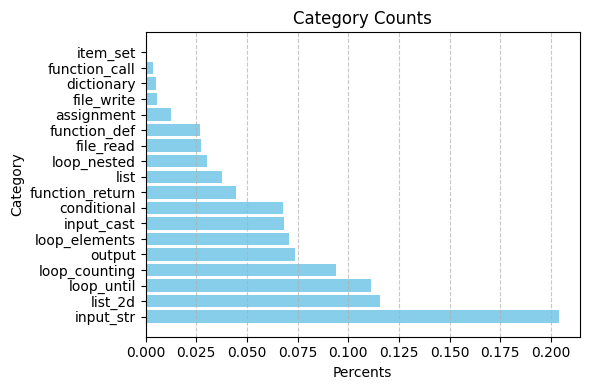

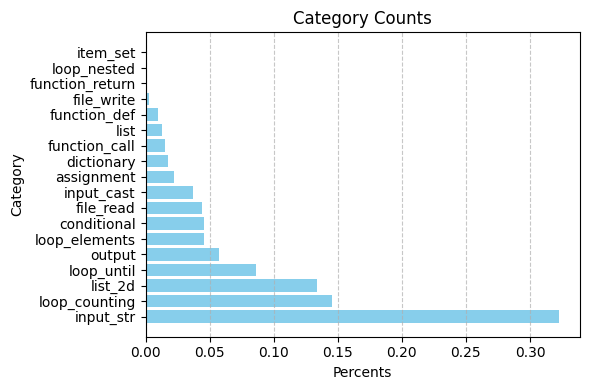

(None, None)

In [49]:
create_graph(struggle_dict), create_graph(not_struggle_dict)

#### Elements according to all question

In [50]:
elements = {
    'IfElse': r'\bif\b|\belif\b|\belse\b',
    'Loops': r'\bfor\s+\w+\s+in\s+range\s*\(.*\)\s*:|\bwhile\s+\w+\s*(==|!=|<|>|<=|>=)\s*\w+\s*:|\bfor\s+\w+\s+in\s+\w+\s*:|for\s+\w+\s+in\s+.*\s*:\s*\n\s*for\s+\w+\s+in',
    'MathOperations': r'\b[\w\s\+\-\*/%]+\b|\b\w+\s*=\s*',
    'StringOperations': r'\binput\s*\(\s*[\'"].*?[\'"]\s*\)|\bprint\s*\(|\bint\s*\(\s*input\s*\(|\bfloat\s*\(\s*input\s*\(|\bstr\s*\(\s*input\s*\(|\binput\s*\(\s*int\s*\(|\binput\s*\(\s*float\s*\(|\binput\s*\(\s*str\s*\(',
    'list': r'\[\s*.*?\s*\]|\[\[.*?\]\]',
    'FileOperations': r'\bopen\s*\(.*,\s*[\'"]r[\'"]\s*\)|\bopen\s*\(.*,\s*[\'"]w[\'"]\s*\)',
    'Functions': r'\b\w+\s*\(.*\)|\bdef\s+\w+\s*\(.*\)\s*:|\breturn\b',
    'Dictionary': r'\{.*:.*\}',
    'Tuple': r'\(.*?,.*?\)|\bset\s*\(.*\)|\{.*\}'
}

In [51]:
questions['IfElse'] = questions['conditional']
questions['Loops'] = questions[["loop_counting", "loop_until", "loop_elements", "loop_nested"]].max(axis=1)
questions['MathOperations'] = questions[["stat_calculate", "assignment"]].max(axis=1)
questions['LogicOperators'] = 0
questions['StringOperations'] = questions[["input_str", "input_cast", "output"]].max(axis=1)
questions["List"]= questions[["list", "list_2d"]].max(axis=1)
questions['FileOperations'] = questions[["file_read", "file_write"]].max(axis=1)
questions["Functions"] = questions[["function_call", "function_def", "function_return"]].max(axis=1)
questions['Dictionary'] = questions["dictionary"]
questions['Tuple'] = questions[["tuple", "item_set"]].max(axis=1)

In [52]:
questions = questions.drop(columns=['input_str', 'input_cast', 'output', 'assignment', 'conditional',
       'function_call', 'function_def', 'function_return', 'loop_counting',
       'loop_until', 'loop_elements', 'loop_nested', 'stat_calculate',
       'file_read', 'file_write', 'list', 'list_2d', 'dictionary', 'item_set',
       'tuple'])


In [53]:
df_computional_constract, problems = create_df_computional_constract(elements)

success
1    35499
0    16864
Name: count, dtype: int64


In [54]:
df['success'].value_counts()

success
1    115056
0     40020
Name: count, dtype: int64

In [55]:
(35499 / 115056).__round__(2), (16864 / 40020).__round__(2)

(0.31, 0.42)

In [56]:
struggle_dict = create_con_dict(df_computional_constract[df_computional_constract['success'] == 0])
not_struggle_dict = create_con_dict(df_computional_constract[df_computional_constract['success'] == 1])

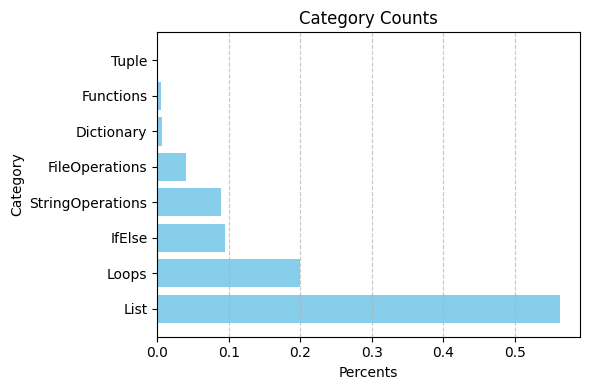

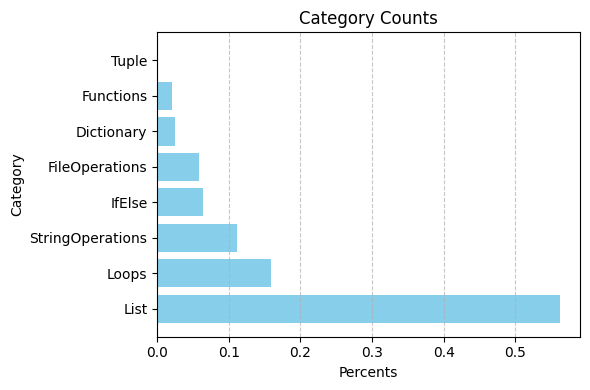

(None, None)

In [57]:
create_graph(struggle_dict), create_graph(not_struggle_dict)